
Training LSTM...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/90
983/983 ━━━━━━━━━━━━━━━━━━━━ 124s 122ms/step - AUC: 0.6390 - BinaryAccuracy: 0.9611 - loss: 0.1629 - val_AUC: 0.7609 - val_BinaryAccuracy: 0.9693 - val_loss: 0.1251
Epoch 2/90
983/983 ━━━━━━━━━━━━━━━━━━━━ 137s 117ms/step - AUC: 0.7821 - BinaryAccuracy: 0.9730 - loss: 0.1097 - val_AUC: 0.7891 - val_BinaryAccuracy: 0.9693 - val_loss: 0.1207
Epoch 3/90
983/983 ━━━━━━━━━━━━━━━━━━━━ 139s 115ms/step - AUC: 0.8062 - BinaryAccuracy: 0.9734 - loss: 0.1049 - val_AUC: 0.8004 - val_BinaryAccuracy: 0.9685 - val_loss: 0.1188
Epoch 4/90
983/983 ━━━━━━━━━━━━━━━━━━━━ 110s 112ms/step - AUC: 0.8265 - BinaryAccuracy: 0.9741 - loss: 0.1005 - val_AUC: 0.8042 - val_BinaryAccuracy: 0.9682 - val_loss: 0.1191
Epoch 5/90
983/983 ━━━━━━━━━━━━━━━━━━━━ 145s 115ms/step - AUC: 0.8383 - BinaryAccuracy: 0.9741 - loss: 0.0993 - val_AUC: 0.8028 - val_BinaryAccuracy: 0.9677 - val_loss: 0.1204
Epoch 6/90
983/983 ━━━━━━━━━━━━━━━━━━━━ 144s 117ms/step - AUC: 0.8537 - BinaryAccuracy: 0.9748 - loss: 0.0950 - val_AUC:

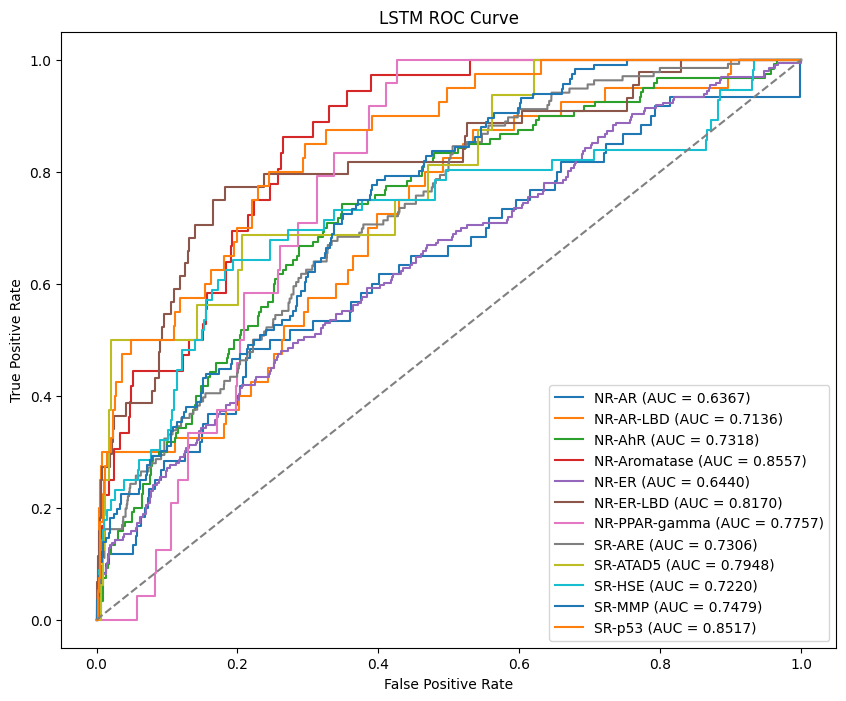


LSTM Mean Accuracy across all targets: 0.9704
LSTM Mean AUC across all targets: 0.7518


In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from rdkit import Chem
from tensorflow.keras.callbacks import EarlyStopping

# === Load Datasets ===
train_df = pd.read_csv("tox21_train.csv")
val_df = pd.read_csv("tox21_val.csv")
test_df = pd.read_csv("tox21_test.csv")

# === Define Targets ===
targets = [
    "NR-AR", "NR-AR-LBD", "NR-AhR", "NR-Aromatase", "NR-ER", "NR-ER-LBD",
    "NR-PPAR-gamma", "SR-ARE", "SR-ATAD5", "SR-HSE", "SR-MMP", "SR-p53"
]

# === SMILES Augmentation Functions ===
def randomize_smiles(smiles, num_aug=5):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return []
    return [Chem.MolToSmiles(mol, doRandom=True) for _ in range(num_aug)]

def augment_dataframe(df, label_columns, num_aug=3):
    augmented_rows = []
    for _, row in df.iterrows():
        base_smiles = row['smiles']
        labels = row[label_columns]
        augmented_rows.append({'smiles': base_smiles, **labels.to_dict()})
        for s in randomize_smiles(base_smiles, num_aug=num_aug):
            augmented_rows.append({'smiles': s, **labels.to_dict()})
    return pd.DataFrame(augmented_rows)

# === Preprocess Each Set ===
train_df = train_df.dropna(subset=["smiles"] + targets)
val_df = val_df.dropna(subset=["smiles"] + targets)
test_df = test_df.dropna(subset=["smiles"] + targets)

# Apply augmentation to training set
train_df = augment_dataframe(train_df, targets, num_aug=3)

# Tokenizer (fit only on augmented training set)
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(train_df["smiles"].astype(str))

def preprocess(df, tokenizer, maxlen=200):
    sequences = tokenizer.texts_to_sequences(df["smiles"].astype(str))
    X = pad_sequences(sequences, maxlen=maxlen)
    Y = df[targets].astype(int).values
    return X, Y

X_train, Y_train = preprocess(train_df, tokenizer)
X_val, Y_val = preprocess(val_df, tokenizer)
X_test, Y_test = preprocess(test_df, tokenizer)
vocab_size = len(tokenizer.word_index) + 1

# === ROC Plot ===
def plot_roc_curve(y_true, y_pred, name):
    plt.figure(figsize=(10, 8))
    for i in range(y_true.shape[1]):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{targets[i]} (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.title(f'{name} ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

# === Model Evaluation ===
def evaluate_model(model, name):
    # Predict on test set
    y_pred = model.predict(X_test)

    # === ROC AUCs and Accuracy per target ===
    aucs = []
    accuracies = []
    for i in range(Y_test.shape[1]):
        try:
            # Calculate ROC AUC
            auc_score = roc_auc_score(Y_test[:, i], y_pred[:, i])
            binary_preds = (y_pred[:, i] > 0.5).astype(int)
            accuracy = accuracy_score(Y_test[:, i], binary_preds)
        except ValueError:
            auc_score = np.nan
            accuracy = np.nan

        aucs.append(auc_score)
        accuracies.append(accuracy)



        # Display ROC AUC and accuracy for the current target
        print(f"{targets[i]:15s}: ROC-AUC = {auc_score:.4f}, Accuracy = {accuracy:.4f}")

    # === Plot ROC Curve ===
    plot_roc_curve(Y_test, y_pred, name)

    # === Mean Accuracy ===
    mean_accuracy = np.mean(accuracies)
    print(f"\n{name} Mean Accuracy across all targets: {mean_accuracy:.4f}")

    # === Mean AUC ===
    mean_auc = np.nanmean(aucs)  # skip NaNs if any targets had no variation
    print(f"{name} Mean AUC across all targets: {mean_auc:.4f}")

    return aucs


# === Model Builders ===
def build_lstm():
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=64, input_length=200),
        LSTM(64),
        Dropout(0.3),
        Dense(12, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC', 'BinaryAccuracy'])
    return model


early_stopping = EarlyStopping(
    monitor='val_loss',   # or 'val_auc' if you prefer
    patience=5,
    restore_best_weights=True
)
# === Train & Evaluate Each Model ===
for name, builder in [("LSTM", build_lstm)]:
    print(f"\nTraining {name}...")
    model = builder()
    model.fit(X_train, Y_train, epochs=90, batch_size=32, validation_data=(X_val, Y_val), callbacks=[early_stopping], verbose=1)
    evaluate_model(model, name)
